In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pickle
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from matplotlib import cm

from training.manifolds import Torus
from training.metric import torus_mmd
from training.sampling import flow_sample, consistency_sample
from datasets.torus_dataset import BoardTorusDataset, ProteinAngles, RNAAngles

In [3]:
def plot_torus(samples):
    """Plot 2D torus heatmap"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    H = ax.hist2d(
        samples[:, 0], samples[:, 1], 300,
        range=((0, 2 * math.pi), (0, 2 * math.pi)),
    )
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    _ = ax.hist2d(
        samples[:, 0], samples[:, 1], 300,
        range=((0, 2 * math.pi), (0, 2 * math.pi)), norm=norm,
    )
    ax.set_aspect('equal')
    ax.set_xlim([0, 2 * math.pi])
    ax.set_ylim([0, 2 * math.pi])
    ax.axis('off')

    plt.tight_layout()
    plt.show()

Data size: torch.Size([166035, 1, 2])


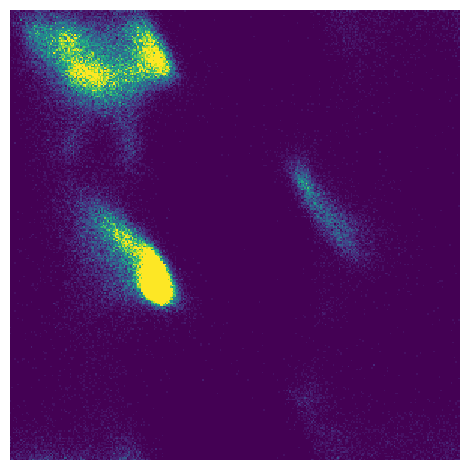

In [4]:
dataset = ProteinAngles('../data/torus/protein.tsv')
# dataset = RNAAngles('../data/torus/rna.tsv')
# dataset = BoardTorusDataset(100000)
print(f'Data size:', dataset.data.size())
plot_torus(dataset.data.squeeze(1).numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.16it/s]


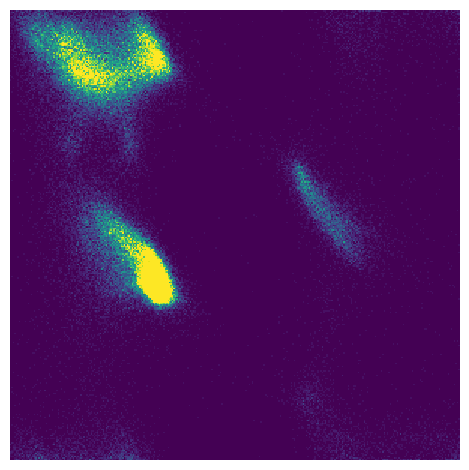

In [5]:
device = 'cuda:0'
ckpt_path = '../training-runs/00005-Protein-flow-gpus1-batch512/network-snapshot-050000.pkl'
n_steps = 100
with open(ckpt_path, 'rb') as f:
    rfm = pickle.load(f)['ema']
rfm.eval()
with torch.no_grad():
    rfm_samples = flow_sample(rfm, Torus(2), n_sample=len(dataset), n_steps=n_steps, device=device).squeeze(1)
plot_torus(rfm_samples.cpu().numpy())

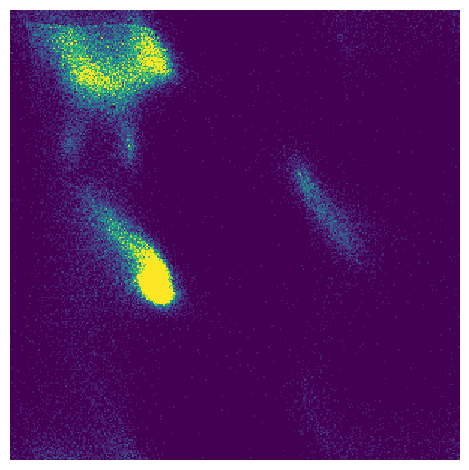

In [ ]:
# Note that on such small datasets, RCD models can overfit quite early. An earlier checkpoint may be better in terms of MMD.
device = 'cuda:0'
ckpt_path = '../consis-training-runs-torus/00005-Protein-Continuous-consistency-gpus1-batch512/network-snapshot-034565.pkl'
with open(ckpt_path, 'rb') as f:
    rcd = pickle.load(f)['ema']
rcd.eval()
with torch.no_grad():
    rcd_samples = consistency_sample(rcd, Torus(2), n_sample=len(dataset), n_steps=2, device=device).squeeze(1)
plot_torus(rcd_samples.cpu().numpy())

In [ ]:
rfm_mmd = torus_mmd(dataset.data.squeeze(1).to(device), rfm_samples, 1)
rcd_mmd = torus_mmd(dataset.data.squeeze(1).to(device), rcd_samples, 1)
print(f'RFM-100 MMD: {rfm_mmd:.5f}, RCD-2 MMD: {rcd_mmd:.5f}')

RFM-100 MMD: 0.00415, RCD-2 MMD: 0.03382
